<a href="https://colab.research.google.com/github/codeSamuraii/ml-experiments/blob/main/CompressionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JPEG Compression detection with Keras
The objective of this notebook is to train a machine learning model to recognise images that have been compressed using a lossy algorithm (such as JPEG) from original high-quality ones.


## Fetching and preparing the dataset files
We'll use a landscape images dataset from Kaggle.

_You'll need to set-up the Kaggle CLI._

```
mkdir ~/.kaggle; echo '{"username":"<username>","key":"<key>"}' > ~/.kaggle/kaggle.json
```



Download the dataset:

In [67]:
!mkdir /content/dataset; cd /content/dataset && kaggle datasets download -d arnaud58/landscape-pictures -w --unzip

100% 620M/620M [00:29<00:00, 24.0MB/s]
100% 620M/620M [00:29<00:00, 22.4MB/s]


Compress the images using Pillow:

In [101]:
!cd /content; rm -rf training; mkdir training; mkdir training/compressed; mkdir training/quality

import os
import pathlib
import tensorflow as tf
from PIL import Image
from itertools import chain


# Images have different extensions
folder = pathlib.Path('dataset')
extensions = {'*.jpg', '*.jpeg'}
images = list(chain.from_iterable(folder.glob(ext) for ext in extensions))
nb_img, nb_errors = len(images), 0
print(f'Found {nb_img} images.')

for i, image_file in enumerate(images):
    try:
      im = Image.open(image_file, formats=['JPEG'])
      im.save(f'training/quality/{i}.jpg', optimize=True, quality='keep')
    except (OSError, ValueError):
      nb_errors += 1
      continue

    im.save(f'training/compressed/{i}.jpg', optimize=False, quality=5)

    if i % 1000 == 0:
        progress = int(i / nb_img * 100)
        print(f'{progress}% ({i}/{nb_img} E={nb_errors})')

print('Done.')

Found 4319 images.
0% (0/4319 E=0)
23% (1000/4319 E=0)
46% (2000/4319 E=0)
69% (3000/4319 E=0)
92% (4000/4319 E=0)
Done.


## Splitting the dataset
Now that we have created our compressed images, let's use Keras to split the dataset between training and validation:

In [119]:
!pip install keras-core keras-cv &> /dev/null

import keras_cv


batch_size = 32
img_height = 800
img_width = 800

train_dataset = tf.keras.utils.image_dataset_from_directory(
  'training',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  # color_mode='grayscale',
  batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  'training',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  # color_mode='grayscale',
  batch_size=batch_size
)

class_names = train_dataset.class_names
num_classes = len(class_names)
print(f'{num_classes} classes: {class_names}')

Found 8638 files belonging to 2 classes.
Using 6911 files for training.
Found 8638 files belonging to 2 classes.
Using 1727 files for validation.
2 classes: ['compressed', 'quality']


Check that pictures have been assigned to the correct label:

Pixel values in [0.0:255.0]


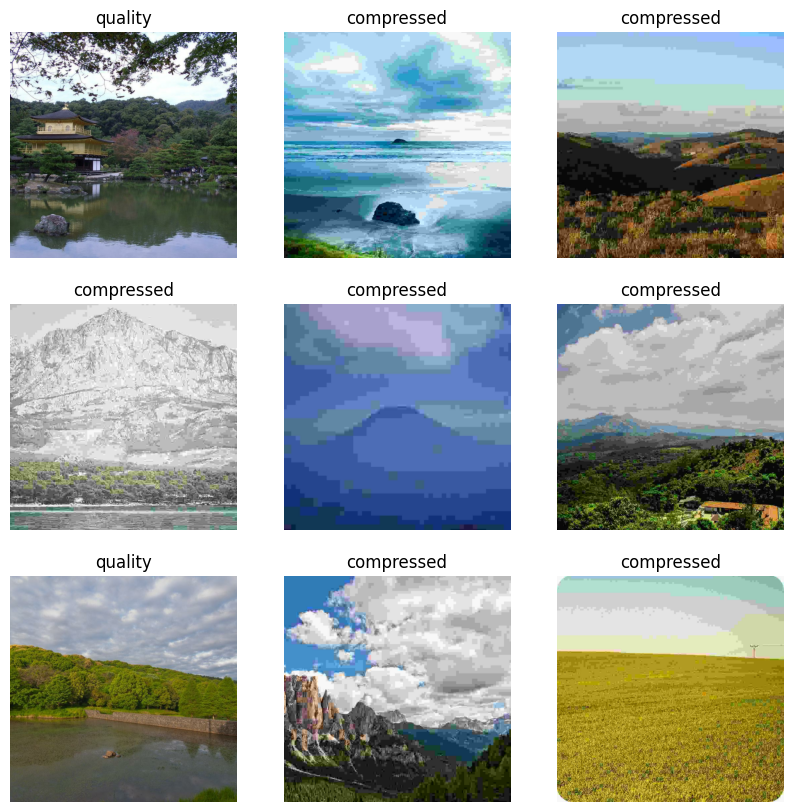

In [108]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

image_batch, _ = next(iter(train_dataset))
first_image = image_batch[0]
print(f'Pixel values in [{np.min(first_image)}:{np.max(first_image)}]')


## Create the model and train
We create a basic CNN network. Note the input shape (height x width x rgb) and the fact that the last dense layer has as many dimensions as we have classes.

In [116]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


preprocess = keras.Sequential([
    layers.RandomFlip(input_shape=(img_height, img_width, 3)),
    layers.RandomZoom((0.0, 0.2)),
    # layers.RandomTranslation(0.2, 0.2, fill_mode='wrap'),
    # layers.RandomContrast((-0.1, 0.1)),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
])


model = Sequential([
  preprocess,

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer='Adamax',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('jpeg_detect_q5_plus.h5', save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(start_from_epoch=5, patience=3, restore_best_weights=True)

history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=[checkpoint, early_stop])

loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)



Epoch 1/20
216/216 [==============================] - 74s 324ms/step - loss: 6.3395 - accuracy: 0.5102 - val_loss: 168.1361 - val_accuracy: 0.4841
Epoch 2/20
216/216 [==============================] - 71s 326ms/step - loss: 0.6911 - accuracy: 0.5232 - val_loss: 19.4999 - val_accuracy: 0.5084
Epoch 3/20
216/216 [==============================] - 71s 325ms/step - loss: 0.6802 - accuracy: 0.5808 - val_loss: 0.6950 - val_accuracy: 0.6543
Epoch 4/20
216/216 [==============================] - 71s 325ms/step - loss: 0.6146 - accuracy: 0.6888 - val_loss: 0.5481 - val_accuracy: 0.7765
Epoch 5/20
216/216 [==============================] - 69s 318ms/step - loss: 0.5286 - accuracy: 0.7764 - val_loss: 0.5539 - val_accuracy: 0.7533
Epoch 6/20
216/216 [==============================] - 70s 320ms/step - loss: 0.4629 - accuracy: 0.8261 - val_loss: 0.7510 - val_accuracy: 0.6051
Epoch 7/20
216/216 [==============================] - 71s 326ms/step - loss: 0.4205 - accuracy: 0.8471 - val_loss: 0.4211 - val

Let's plot the training statistics :

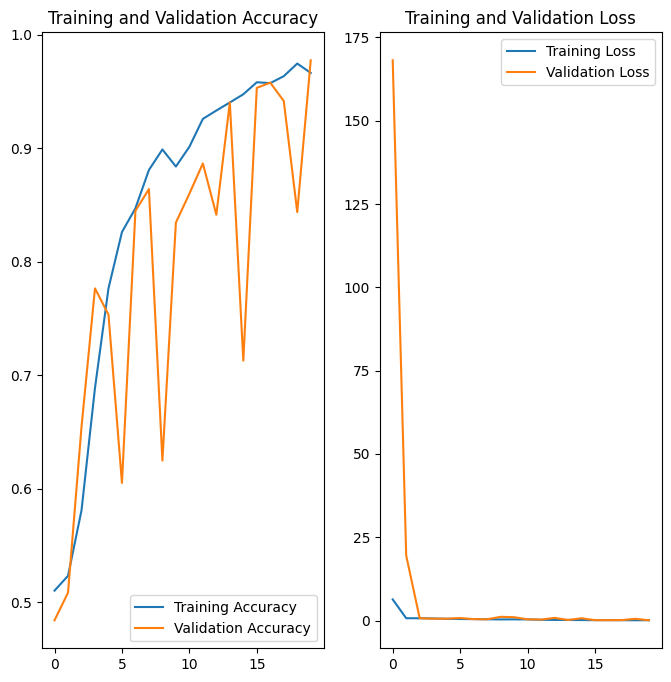

In [117]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
nb_epochs = len(history.history['val_loss'])
epochs_range = range(nb_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [118]:
import numpy as np
from random import randint, choice

img = tf.keras.utils.load_img(
    f'training/quality/{randint(0,500)}.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 133ms/step
This image most likely belongs to quality with a 73.11 percent confidence.
